In [34]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from torch.autograd import Variable
from tqdm import tqdm

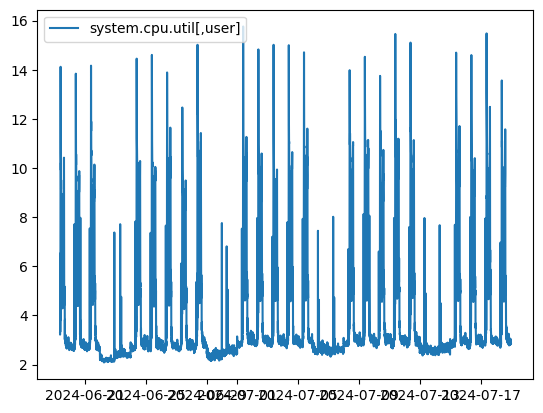

In [2]:
base_path = Path('./data/dfyj/')
key1_path = base_path.joinpath('key1_20240618_20240718')
ip = '8.27.105.214'

# Read the CSV file and parse the timestamp field
df_key1 = pd.read_csv(key1_path.joinpath(ip + '.csv'),
                      parse_dates=['timestamp'])

# Extract the relevant columns
maxstatsvalue_key1 = df_key1['maxstatsvalue']

# Extract the timestamps
timestamps = df_key1['timestamp']

# Plot the data
plt.plot(timestamps, maxstatsvalue_key1, label='system.cpu.util[,user]')
plt.legend()
plt.show()

In [3]:
training_vals = np.array([maxstatsvalue_key1])
training_vals

array([[3.287156, 3.220238, 3.447556, ..., 2.827642, 2.896957, 2.8857  ]])

In [12]:
def sliding_windows(data: np.ndarray, seq_length: int):
    x = []
    y = []

    for i in range(len(data)-seq_length-1-seq_length-24*12):
        _x = data[i:(i+seq_length)]
        x.append(_x)

        # y is the max of the respective next day
        _y = np.max(data[i+seq_length+24*12: i +
                    seq_length+24*12+seq_length])
        y.append(_y)

    return np.array(x), np.array(y)


sc = MinMaxScaler()
training_data = sc.fit_transform(
    training_vals.transpose()
)

seq_length = 7*24*12
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [17]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [20]:
num_epochs = 40
learning_rate = 0.01

input_size = 1
hidden_size = 16
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in (prog := tqdm(range(num_epochs))):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs.squeeze(), trainY)

    loss.backward()

    optimizer.step()
    prog.set_description(f'Loss: {loss.item()}')

Loss: 0.004079699050635099: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it] 


In [35]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

print('Test RMSE: %.5f' % root_mean_squared_error(dataY_plot, data_predict))
print('Test MAPE: %.5f' %
      mean_absolute_percentage_error(dataY_plot, data_predict))

Test RMSE: 0.05987
Test MAPE: 0.05784
